In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import os
import time
import random

print(tf.__version__)
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from keras.initializers import RandomNormal

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Conv1DTranspose,AveragePooling1D,GlobalMaxPool1D,GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D,MaxPool2D,Conv2DTranspose,AveragePooling2D,GlobalMaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv3D,MaxPooling3D,Conv3DTranspose,AveragePooling3D,GlobalMaxPool3D,GlobalAveragePooling3D
from tensorflow.keras.layers import Dense,Flatten,Dropout,Concatenate,Layer,BatchNormalization,Input,Add,Activation,Average

from tensorflow.keras import layers

2.10.1


In [2]:
from tensorflow.keras import callbacks
from tensorflow.keras import layers, regularizers
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow import keras
import tensorflow as tf


l2 = regularizers.l2
w_decay=1e-8 #0.0#2e-4#1e-3, 2e-4 # please define weight decay
K.clear_session()
# weight_init = tf.initializers.RandomNormal(mean=0.,stddev=0.01)
# weight_init = tf.initializers.glorot_normal()
weight_init = tf.initializers.glorot_normal()

class _DenseLayer(layers.Layer):
    """_DenseBlock model.

       Arguments:
         out_features: number of output features
    """

    def __init__(self, out_features,**kwargs):
        super(_DenseLayer, self).__init__(**kwargs)
        k_reg = None if w_decay is None else l2(w_decay)
        self.layers = []
        self.layers.append(tf.keras.Sequential(
            [
                layers.ReLU(),
                layers.Conv2D(
                    filters=out_features, kernel_size=(3,3), strides=(1,1), padding='same',
                    use_bias=True, kernel_initializer=weight_init,
                kernel_regularizer=k_reg),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Conv2D(
                    filters=out_features, kernel_size=(3,3), strides=(1,1), padding='same',
                    use_bias=True, kernel_initializer=weight_init,
                    kernel_regularizer=k_reg),
                layers.BatchNormalization(),
            ])) # first relu can be not needed


    def call(self, inputs):
        x1, x2 = tuple(inputs)
        new_features = x1
        for layer in self.layers:
            new_features = layer(new_features)

        return 0.5 * (new_features + x2), x2


class _DenseBlock(layers.Layer):
    """DenseBlock layer.

       Arguments:
         num_layers: number of _DenseLayer's per block
         out_features: number of output features
    """

    def __init__(self,
                 num_layers,
                 out_features,**kwargs):
        super(_DenseBlock, self).__init__(**kwargs)
        self.layers = [_DenseLayer(out_features) for i in range(num_layers)]

    def call(self, inputs):
        for layer in self.layers:
            inputs = layer(inputs)

        return inputs


class UpConvBlock(layers.Layer):
    """UpConvDeconvBlock layer.

       Arguments:
         up_scale: int
    """

    def __init__(self, up_scale,**kwargs):
        super(UpConvBlock, self).__init__(**kwargs)
        constant_features = 16
        k_reg = None if w_decay is None else l2(w_decay)
        features = []
        total_up_scale = 2 ** up_scale
        for i in range(up_scale):
            out_features = 1 if i == up_scale-1 else constant_features
            if i==up_scale-1:
                features.append(layers.Conv2D(
                    filters=out_features, kernel_size=(1,1), strides=(1,1), padding='same',
                    activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.),
                    kernel_regularizer=k_reg,use_bias=True)) #tf.initializers.TruncatedNormal(mean=0.)
                features.append(layers.Conv2DTranspose(
                    out_features, kernel_size=(total_up_scale,total_up_scale),
                    strides=(2,2), padding='same',
                    kernel_initializer=tf.initializers.RandomNormal(stddev=0.1),
                    kernel_regularizer=k_reg,use_bias=True)) # stddev=0.1
            else:

                features.append(layers.Conv2D(
                    filters=out_features, kernel_size=(1,1), strides=(1,1), padding='same',
                    activation='relu',kernel_initializer=weight_init,
                kernel_regularizer=k_reg,use_bias=True))
                features.append(layers.Conv2DTranspose(
                    out_features, kernel_size=(total_up_scale,total_up_scale),
                    strides=(2,2), padding='same', use_bias=True,
                    kernel_initializer=weight_init, kernel_regularizer=k_reg))

        self.features = keras.Sequential(features)

    def call(self, inputs):
        return self.features(inputs)


class SingleConvBlock(layers.Layer):
    """SingleConvBlock layer.

       Arguments:
         out_features: number of output features
         stride: stride per convolution
    """

    def __init__(self, out_features, k_size=(1,1),stride=(1,1),
                 use_bs=False, use_act=False,w_init=None,**kwargs): # bias_init=tf.constant_initializer(0.0)
        super(SingleConvBlock, self).__init__(**kwargs)
        self.use_bn = use_bs
        self.use_act = use_act
        k_reg = None if w_decay is None else l2(w_decay)
        self.conv = layers.Conv2D(
            filters=out_features, kernel_size=k_size, strides=stride,
            padding='same',kernel_initializer=w_init,
            kernel_regularizer=k_reg)#, use_bias=True, bias_initializer=bias_init
        if self.use_bn:
            self.bn = layers.BatchNormalization()
        if self.use_act:
            self.relu = layers.ReLU()

    def call(self, inputs):
        x =self.conv(inputs)
        if self.use_bn:
            x = self.bn(x)
        if self.use_act:
            x = self.relu(x)
        return x


class DoubleConvBlock(layers.Layer):
    """DoubleConvBlock layer.

       Arguments:
         mid_features: number of middle features
         out_features: number of output features
         stride: stride per mid-layer convolution
    """

    def __init__(self, mid_features, out_features=None, stride=(1,1),
                 use_bn=True,use_act=True,**kwargs):
        super(DoubleConvBlock, self).__init__(**kwargs)
        self.use_bn =use_bn
        self.use_act =use_act
        out_features = mid_features if out_features is None else out_features
        k_reg = None if w_decay is None else l2(w_decay)

        self.conv1 = layers.Conv2D(
            filters=mid_features, kernel_size=(3, 3), strides=stride, padding='same',
        use_bias=True, kernel_initializer=weight_init,
        kernel_regularizer=k_reg)
        self.bn1 = layers.BatchNormalization()

        self.conv2 = layers.Conv2D(
            filters=out_features, kernel_size=(3, 3), padding='same',strides=(1,1),
        use_bias=True, kernel_initializer=weight_init,
        kernel_regularizer=k_reg)
        self.bn2 = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.use_act:
            x = self.relu(x)
        return x


class DexiNed(tf.keras.Model):
    """DexiNet model."""

    def __init__(self,rgb_mean=None,
                 **kwargs):
        super(DexiNed, self).__init__(**kwargs)

        self.rgbn_mean = rgb_mean
        self.block_1 = DoubleConvBlock(32, 64, stride=(2,2),use_act=False)
        self.block_2 = DoubleConvBlock(128,use_act=False)
        self.dblock_3 = _DenseBlock(2, 256)
        self.dblock_4 = _DenseBlock(3, 512)
        self.dblock_5 = _DenseBlock(3, 512)
        self.dblock_6 = _DenseBlock(3, 256)
        self.maxpool = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same')

        # left skip connections, figure in Journal
        self.side_1 = SingleConvBlock(128,k_size=(1,1),stride=(2,2),use_bs=True,
                                      w_init=weight_init)
        self.side_2 = SingleConvBlock(256,k_size=(1,1),stride=(2,2),use_bs=True,
                                      w_init=weight_init)
        self.side_3 = SingleConvBlock(512,k_size=(1,1),stride=(2,2),use_bs=True,
                                      w_init=weight_init)
        self.side_4 = SingleConvBlock(512,k_size=(1,1),stride=(1,1),use_bs=True,
                                      w_init=weight_init)
        # self.side_5 = SingleConvBlock(256,k_size=(1,1),stride=(1,1),use_bs=True,
        #                               w_init=weight_init)

        # right skip connections, figure in Journal paper
        self.pre_dense_2 = SingleConvBlock(256,k_size=(1,1),stride=(2,2),
                                      w_init=weight_init) # use_bn=True
        self.pre_dense_3 = SingleConvBlock(256,k_size=(1,1),stride=(1,1),use_bs=True,
                                      w_init=weight_init)
        self.pre_dense_4 = SingleConvBlock(512,k_size=(1,1),stride=(1,1),use_bs=True,
                                      w_init=weight_init)
        # self.pre_dense_5_0 = SingleConvBlock(512, k_size=(1,1),stride=(2,2),
        #                               w_init=weight_init) # use_bn=True
        self.pre_dense_5 = SingleConvBlock(512,k_size=(1,1),stride=(1,1),use_bs=True,
                                      w_init=weight_init)
        self.pre_dense_6 = SingleConvBlock(256,k_size=(1,1),stride=(1,1),use_bs=True,
                                      w_init=weight_init)
        # USNet
        self.up_block_1 = UpConvBlock(1)
        self.up_block_2 = UpConvBlock(1)
        self.up_block_3 = UpConvBlock(2)
        self.up_block_4 = UpConvBlock(3)
        self.up_block_5 = UpConvBlock(4)
        self.up_block_6 = UpConvBlock(4)

        self.block_cat = SingleConvBlock(
            1,k_size=(1,1),stride=(1,1),
            w_init=tf.constant_initializer(1/5))


    def slice(self, tensor, slice_shape):
        height, width = slice_shape
        return tensor[..., :height, :width]


    def call(self, x):
        # Block 1
        x = x-self.rgbn_mean[:-1]
        block_1 = self.block_1(x)
        block_1_side = self.side_1(block_1)

        # Block 2
        block_2 = self.block_2(block_1)
        block_2_down = self.maxpool(block_2) # the key for the second skip connec...
        block_2_add = block_2_down + block_1_side
        block_2_side = self.side_2(block_2_add) #

        # Block 3
        block_3_pre_dense = self.pre_dense_3(block_2_down)
        block_3, _ = self.dblock_3([block_2_add, block_3_pre_dense])
        block_3_down = self.maxpool(block_3)
        block_3_add = block_3_down + block_2_side
        block_3_side = self.side_3(block_3_add)

        # Block 4
        block_4_pre_dense_256 = self.pre_dense_2(block_2_down)
        block_4_pre_dense = self.pre_dense_4(block_4_pre_dense_256 + block_3_down)
        block_4, _ = self.dblock_4([block_3_add, block_4_pre_dense])
        block_4_down = self.maxpool(block_4)
        block_4_add = block_4_down + block_3_side
        block_4_side = self.side_4(block_4_add)

        # Block 5
        # block_5_pre_dense_512 = self.pre_dense_5_0(block_4_pre_dense_256)
        block_5_pre_dense = self.pre_dense_5(block_4_down )
        block_5, _ = self.dblock_5([block_4_add, block_5_pre_dense])
        block_5_add = block_5 + block_4_side

        # Block 6
        block_6_pre_dense = self.pre_dense_6(block_5)
        block_6, _ = self.dblock_6([block_5_add, block_6_pre_dense])

        # upsampling blocks
        height, width = x.shape[1:3]
        slice_shape = (height, width)
        out_1 = self.up_block_1(block_1) # self.slice(, slice_shape)
        out_2 = self.up_block_2(block_2)
        out_3 = self.up_block_3(block_3)
        out_4 = self.up_block_4(block_4)
        out_5 = self.up_block_5(block_5)
        out_6 = self.up_block_6(block_6)
        results = [out_1, out_2, out_3, out_4, out_5, out_6]

        # concatenate multiscale outputs
        block_cat = tf.concat(results, 3)  # BxHxWX6
        block_cat = self.block_cat(block_cat)  # BxHxWX1

        results.append(block_cat)

        return results

def weighted_cross_entropy_loss(input, label):
    y = tf.cast(label,dtype=tf.float32)
    negatives = tf.math.reduce_sum(1.-y)
    positives = tf.math.reduce_sum(y)

    beta = negatives/(negatives + positives)
    pos_w = beta/(1-beta)
    cost = tf.nn.weighted_cross_entropy_with_logits(
    labels=label, logits=input, pos_weight=pos_w, name=None)
    cost = tf.reduce_sum(cost*(1-beta))
    return tf.where(tf.equal(positives, 0.0), 0.0, cost)


def pre_process_binary_cross_entropy(bc_loss,input, label,arg, use_tf_loss=False):
    # preprocess data
    y = label
    loss = 0
    w_loss=1.0
    preds = []
    for tmp_p in input:
        # tmp_p = input[i]

        # loss processing
        tmp_y = tf.cast(y, dtype=tf.float32)
        mask = tf.dtypes.cast(tmp_y > 0., tf.float32)
        b,h,w,c=mask.get_shape()
        positives = tf.math.reduce_sum(mask, axis=[1, 2, 3], keepdims=True)
        negatives = h*w*c-positives

        beta2 = (1.*positives) / (negatives + positives) # negatives in hed
        beta = (1.1*negatives)/ (positives + negatives) # positives in hed
        pos_w = tf.where(tf.equal(y, 0.0), beta2, beta)
        logits = tf.sigmoid(tmp_p)

        l_cost = bc_loss(y_true=tmp_y, y_pred=logits,
                         sample_weight=pos_w)

        preds.append(logits)
        loss += (l_cost*w_loss)

    return preds, loss

In [3]:
#data_path = "outlineOutput"
data_path = "I:\\tmp\\datasets\\tinyDexinedDataset"
output_path = "H:\\tmp\\dexined"
#data_path = "/media/Tomasz/4T/work/dexined/outlineOutput"

#data_path = "/media/Tomasz/4T/work/dexined/tmp/largeEdgeDetectionDataset"
#output_path = "/media/Tomasz/4T/work/dexined/tmp/teed/jasny"


train_path = data_path + "/train/*"
edge_train_path = data_path + "/train_edge/*"

test_path = data_path + "/test/*"
edge_test_path = data_path + "/test_edge/*"

val_path = data_path + "/val/*"
edge_val_path = data_path + "/val_edge/*"

print(edge_test_path)

I:\tmp\datasets\tinyDexinedDataset/test_edge/*


In [4]:
def load_data(ipath, epath,pattern):
    pattern_ipath = ipath + "*" +pattern+"*"
    pattern_epath = epath + "*" +pattern+"*"
    images = sorted(glob(os.path.join(pattern_ipath)))
    edges = sorted(glob(os.path.join(pattern_epath)))
    images = np.array(images)
    edges = np.array(edges)
    
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)

    images = images[indices]
    edges = edges[indices]
    return images.tolist(), edges.tolist()

In [5]:
images, edges = load_data(train_path, edge_train_path,"*")
valimg, valedg = load_data(val_path, edge_val_path,"*")
print(len(images), len(edges))
print(len(valimg), len(valedg))

200 200
38 38


In [6]:
def read_image(path, H=512, W=912):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W,H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_edge(path, H=512, W=912):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W,H))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    x = x.astype(np.float32)
    return x

def preprocess(x,y,H=512, W=912):

    def f(x,y):
        #print(x,"|||",y)
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_edge(y)
        return x, y

    images, edges = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([H, W, 3])
    edges.set_shape([H, W, 1])
    return images, edges

AUTOTUNE = tf.data.AUTOTUNE

def tf_data(x,y):
    data = tf.data.Dataset.from_tensor_slices((x,y))
    data = data.cache()
    data = data.shuffle(buffer_size=1000)
    data = data.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data = data.batch(2)
    data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return data

In [7]:
train_data = tf_data(images, edges)
val_data = tf_data(valimg, valedg)

print(len(train_data),len(val_data))


100 19


In [8]:
class GPUMemoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_batches, print_stats=False, **kwargs):
        """
        target_batches: A list of batch indices at which to record memory usage.
        print_stats: A boolean flag indicating whether to print memory usage statistics.
        """
        super().__init__(**kwargs)
        self.target_batches = target_batches
        self.print_stats = print_stats

        self.memory_usage = []
        self.labels = []

    def _compute_memory_usage(self):
        memory_stats = tf.config.experimental.get_memory_info("GPU:0")
        # Convert bytes to GB and store in list.
        peak_usage = round(memory_stats["peak"] / (2**30), 3)
        self.memory_usage.append(peak_usage)

    def on_epoch_begin(self, epoch, logs=None):
        self._compute_memory_usage()
        self.labels.append(f"epoch {epoch} start")

    def on_train_batch_begin(self, batch, logs=None):
        if batch in self.target_batches:
            self._compute_memory_usage()
            self.labels.append(f"batch {batch}")

    def on_epoch_end(self, epoch, logs=None):
        self._compute_memory_usage()
        self.labels.append(f"epoch {epoch} end")
        
gpu_memory_callback = GPUMemoryCallback(
    target_batches=[1, 2, 3],
    print_stats=True,
)

In [15]:
model_filepath = output_path + "/dexined-allindataset-{epoch:02d}-{output_1_binary_accuracy:.4f}.hdf5"
checkpoint =ModelCheckpoint(
    filepath=model_filepath,
    save_weights_only=True,
    monitor='output_7_binary_accuracy',
    mode='max',
    save_best_only=False,
    verbose=1)
    

In [10]:
my_model = DexiNed(rgb_mean=[103.939,116.779,123.68, 137.86])


In [11]:
my_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[tf.keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.FalseNegatives(),
             tf.keras.metrics.FalsePositives(),
             tf.keras.metrics.TruePositives(),
            tf.keras.metrics.TrueNegatives()])

In [12]:
train_steps=len(train_data)
val_steps=len(val_data)
print(train_steps)
H = my_model.fit(train_data, validation_data=val_data, epochs=3, steps_per_epoch=train_steps, validation_steps=val_steps, callbacks=[checkpoint,gpu_memory_callback])

100
Epoch 1/3


H:\download\anaconda3_envs\generativeTensorflowCudaV2\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


100/100 [==============================] - ETA: 0s - loss: 0.3690 - output_1_loss: 0.0519 - output_2_loss: 0.0539 - output_3_loss: 0.0520 - output_4_loss: 0.0529 - output_5_loss: 0.0528 - output_6_loss: 0.0512 - output_7_loss: 0.0541 - output_1_binary_accuracy: 0.6431 - output_1_false_negatives: 33327132.0000 - output_1_false_positives: 0.0000e+00 - output_1_true_positives: 0.0000e+00 - output_1_true_negatives: 60061680.0000 - output_2_binary_accuracy: 0.6428 - output_2_false_negatives: 33311416.0000 - output_2_false_positives: 27992.0000 - output_2_true_positives: 15714.0000 - output_2_true_negatives: 60033688.0000 - output_3_binary_accuracy: 0.6431 - output_3_false_negatives: 33327132.0000 - output_3_false_positives: 0.0000e+00 - output_3_true_positives: 0.0000e+00 - output_3_true_negatives: 60061680.0000 - output_4_binary_accuracy: 0.6431 - output_4_false_negatives: 33327132.0000 - output_4_false_positives: 0.0000e+00 - output_4_true_positives: 0.0000e+00 - output_4_true_negatives: 

Epoch 3/3
100/100 [==============================] - ETA: 0s - loss: 0.3530 - output_1_loss: 0.0505 - output_2_loss: 0.0509 - output_3_loss: 0.0501 - output_4_loss: 0.0501 - output_5_loss: 0.0501 - output_6_loss: 0.0501 - output_7_loss: 0.0512 - output_1_binary_accuracy: 0.6431 - output_1_false_negatives: 33327128.0000 - output_1_false_positives: 0.0000e+00 - output_1_true_positives: 0.0000e+00 - output_1_true_negatives: 60061680.0000 - output_2_binary_accuracy: 0.6431 - output_2_false_negatives: 33327128.0000 - output_2_false_positives: 0.0000e+00 - output_2_true_positives: 0.0000e+00 - output_2_true_negatives: 60061680.0000 - output_3_binary_accuracy: 0.6431 - output_3_false_negatives: 33327128.0000 - output_3_false_positives: 0.0000e+00 - output_3_true_positives: 0.0000e+00 - output_3_true_negatives: 60061680.0000 - output_4_binary_accuracy: 0.6431 - output_4_false_negatives: 33327128.0000 - output_4_false_positives: 0.0000e+00 - output_4_true_positives: 0.0000e+00 - output_4_true_n

In [31]:
my_model.summary()

Model: "dexi_ned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 double_conv_block (DoubleCo  multiple                 19776     
 nvBlock)                                                        
                                                                 
 double_conv_block_1 (Double  multiple                 222464    
 ConvBlock)                                                      
                                                                 
 private__dense_block (_Dens  multiple                 2069504   
 eBlock)                                                         
                                                                 
 private__dense_block_1 (_De  multiple                 12991488  
 nseBlock)                                                       
                                                                 
 private__dense_block_2 (_De  multiple                 141

In [ ]:
#my_model.load_weights("H:\\tmp\\dexined\\dexined-allindataset-03-0.6431.hdf5")

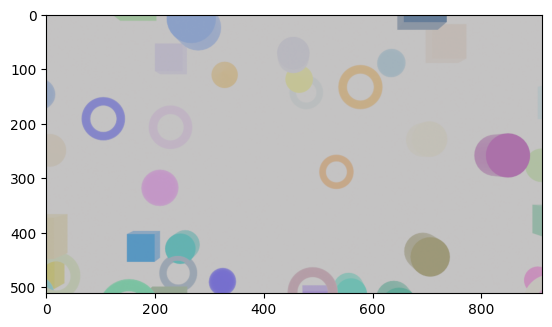

In [22]:
img_pre = read_image('I:\\tmp\\datasets\\tinyDexinedDataset2\\test\\dense_781.png')

img = np.expand_dims(img_pre, axis=0)
plt.imshow(img_pre)

In [29]:
res_pre = my_model.predict(img)
#res = res_pre[-1,:,:]
#plt.imshow(res_pre)

1/1 [==============================] - 0s 262ms/step


(1, 512, 912, 1)
(1, 512, 912, 1)
(1, 512, 912, 1)
(1, 512, 912, 1)
(1, 512, 912, 1)
(1, 512, 912, 1)
(1, 512, 912, 1)


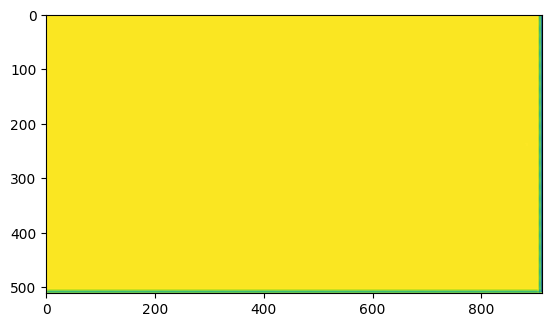

In [30]:
for i in res_pre:
    print(i.shape)
    res = i[-1,:,:]
    plt.imshow(res)